In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, seaborn as sns, astropy, matplotlib as mpl
from matplotlib.lines import Line2D
from astropy.io import fits, ascii as ascii_io
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
simbad = pd.read_csv("./catalogs/1602003777252A.csv",dtype={'id':str})
gaia_result = pd.read_csv("./catalogs/gaia_BeSS.tsv", delimiter="|")
gaia_result[["epsi","AG","rest"]] = gaia_result[["epsi","AG","rest"]].apply(pd.to_numeric, errors="coerce")
gaia_result["$N_H$ (×$10^{21}$)"] = gaia_result.loc[:,"AG"].values*2.2e21
gaia_result["DR2Name"] = [entry.split()[-1] for entry in gaia_result["DR2Name"]]
total = pd.merge(simbad,gaia_result,left_on="id", right_on="DR2Name")[["Be star","main_type","a_g_val","DR2Name","rest_x","rest_y","epsi","AG","$N_H$ (×$10^{21}$)"]]

old = pd.read_csv("./catalogs/BeSS+Gaia+HMXBs+CSC+XMM.csv")
total = pd.merge(total,old[["Be star","_2CXO","_4XMM"]],on="Be star")
total.drop(columns=["rest_y"],inplace=True)
total.rename(columns={"rest_x":"rest"},inplace=True)

In [3]:
for i in total.index:
    if pd.isna(total.loc[i,"_2CXO"]) and pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia only"
    elif pd.isna(total.loc[i,"_2CXO"]):
        total.loc[i,"Catalog membership"] = "Gaia+XMM"
    elif pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia+Chandra"
    else:
        total.loc[i,"Catalog membership"] = "Gaia+Chandra+XMM"

In [4]:
interesting = total[~total["main_type"].isin(["Ae*","Be*","*","Em*","Star"])]
np.unique(interesting["main_type"])

array([&#39;**&#39;, &#39;*in**&#39;, &#39;*inNeb&#39;, &#39;BlueSG*&#39;, &#39;Candidate_Be*&#39;,
       &#39;Candidate_RGB*&#39;, &#39;Candidate_YSO&#39;, &#39;Cl*&#39;, &#39;EB*&#39;, &#39;EB*Algol&#39;,
       &#39;EB*WUMa&#39;, &#39;EB*betLyr&#39;, &#39;Eruptive*&#39;, &#39;HII&#39;, &#39;HMXB&#39;, &#39;IR&#39;,
       &#39;Orion_V*&#39;, &#39;Pec*&#39;, &#39;PulsV*&#39;, &#39;PulsV*bCep&#39;, &#39;Radio&#39;,
       &#39;Radio(sub-mm)&#39;, &#39;RfNeb&#39;, &#39;RotV*alf2CVn&#39;, &#39;SB*&#39;, &#39;SG*&#39;, &#39;V*&#39;,
       &#39;WR*&#39;, &#39;YSO&#39;, &#39;multiple_object&#39;, &#39;post-AGB*&#39;], dtype=object)

In [5]:
for i in interesting.index:
    if interesting.loc[i,"main_type"] in ["Star",'*  ','~  ', "s*b","IR","HII","sg*","SG*","post-AGB*","RB?","Candidate_Be*","Candidate_RGB*","BlueSG*","Radio","Radio(sub-mm)","Cl*"]:
        interesting.drop(i, axis=0, inplace=True)
    elif interesting.loc[i,"main_type"] in ["Al*","EB*","SB*","** ","**","WU*","bL*","*in**",'EB*WUMa', 'EB*betLyr','EB*Algol',"multiple_object"]:
        interesting.loc[i,"Class"] = "Binary"
    elif interesting.loc[i,"main_type"] in ["Pe*","WR*","Pec*"]:
        interesting.loc[i,"Class"] = "Peculiar/WR"
    elif interesting.loc[i,"main_type"] in ["Y*?", "Y*O","Candidate_YSO","YSO"]:
        interesting.loc[i,"Class"] = "YSO"
    elif interesting.loc[i,"main_type"] in ["*iN","pA*","*inNeb","RfNeb"]:
        interesting.loc[i,"Class"] = "Nebular"
    elif interesting.loc[i,"main_type"] in ["Eruptive*","Er*","Orion_V*","Pu*","V* ",'a2*','bC*',"V*","PulsV*bCep","PulsV*","RotV*alf2CVn"]:
        interesting.loc[i,"Class"] = "Variable"
    elif interesting.loc[i,"main_type"] in ["HXB","HMXB"]:
        interesting.loc[i,"Class"] = "HMXB"

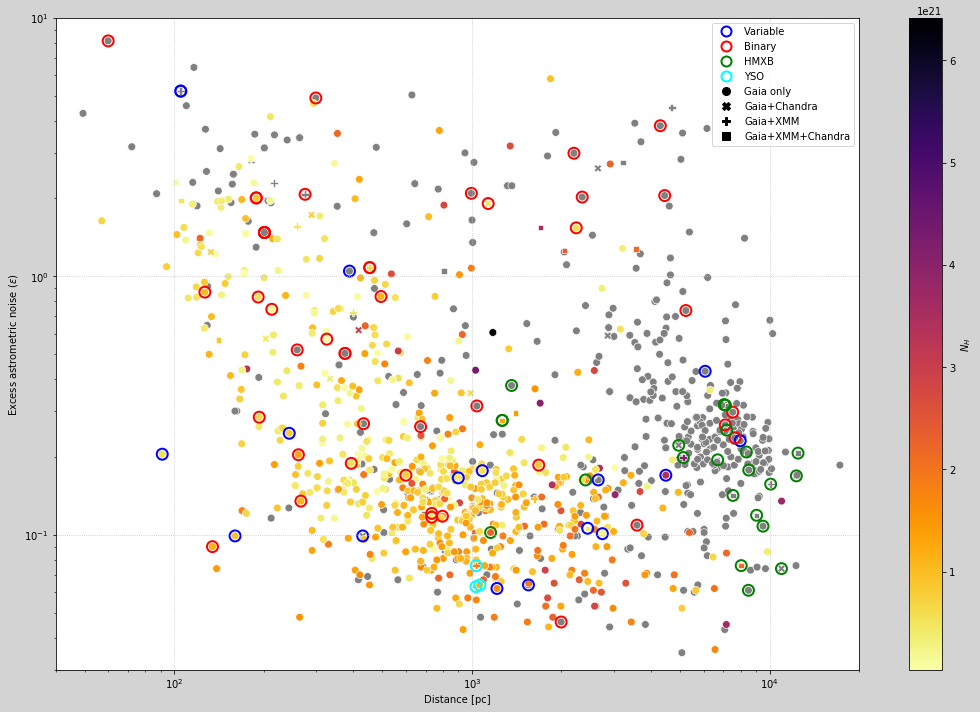

In [6]:
fig, ax = plt.subplots(figsize=(18,12), facecolor="lightgrey")
plt.grid(color="silver",linestyle=":")

plot_instance = sns.scatterplot(data=total[total["$N_H$ (×$10^{21}$)"].isna()], x="rest", y="epsi", color="grey", style="Catalog membership", s=60, ax=ax, legend=False)

sns.scatterplot(data=total[~total["$N_H$ (×$10^{21}$)"].isna()],x="rest",y="epsi",hue="$N_H$ (×$10^{21}$)",palette="inferno_r",style="Catalog membership",s=60,ax=ax, legend=False)

ax.scatter(interesting[interesting["Class"]=="Variable"]["rest"], interesting[interesting["Class"]=="Variable"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="b", label="Variable")
ax.scatter(interesting[interesting["Class"]=="Binary"]["rest"], interesting[interesting["Class"]=="Binary"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="r", label="Binary")
#ax.scatter(interesting[interesting["Class"]=="Nebular"]["rest"], interesting[interesting["Class"]=="Nebular"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="r", label="Nebular")
ax.scatter(interesting[interesting["Class"]=="HMXB"]["rest"], interesting[interesting["Class"]=="HMXB"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="g", label="HMXB")
ax.scatter(interesting[interesting["Class"]=="YSO"]["rest"], interesting[interesting["Class"]=="YSO"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="cyan", label="YSO")
#ax.scatter(interesting[interesting["Class"]=="Peculiar/WR"]["rest"], interesting[interesting["Class"]=="Peculiar/WR"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="yellow", label="Peculiar/WR")

ax.set(ylim=(3e-2,10), xlim=(40,20000), xscale="log", yscale="log", xlabel="Distance [pc]", ylabel="Excess astrometric noise ($\epsilon$)")

plot_instance.figure.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["$N_H$ (×$10^{21}$)"].min(), vmax=total["$N_H$ (×$10^{21}$)"].max(), clip=False), cmap='inferno_r'),label='$N_H$')

legend_elements = [Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='b', label='Variable', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='r', label='Binary', markersize=10, mew=2),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='r', label='Nebular', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='g', label='HMXB', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='YSO', markersize=10, mew=2),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='yellow', label='Peculiar', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', color="k", label='Gaia only', markersize=8),
                   Line2D([0], [0], linestyle="", marker='X', color="k", label='Gaia+Chandra', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color="k", label='Gaia+XMM', markersize=8),
                   Line2D([0], [0], linestyle="", marker='s', color="k", label='Gaia+XMM+Chandra', markersize=8)]

ax.legend(handles=legend_elements, loc='upper right')

fig.savefig("./plots/gaia_epsi_vs_rest.png",bbox_inches="tight",dpi=300,facecolor="lightgrey")